# Making Expressions Regular: How to Do Regular Expressions in Python

## Introduction

There are a multitude of situations in which we deal with text when we program. We could be working on gathering text from messy, scraped webpages. We could be filtering data from a corpus of literature to perform statistical analyses. We could even be determining whether data submitted to us from a public interface is valid and secure. 

If you've worked in any of these environments, you might've heard of regular expressions. Regular expressions are a highly useful tool in situations like these. They serve as a flexible tool for pattern recognition. When paired with a programming library, such as Python's native `re` module, regular expressions can be weaponized for gathering, filtering, or cleaning text.

At the same time, regular expressions can seem like an intimidating formalism. On the one hand, they're based on theoretical principles that we use to analyze language; this, at times, can seem cryptic and abstract. On the other hand, their notation in practice varies depending on the programming language, and the variety of syntactic sugar used to make writing them easier can be a lot to comprehend and learn.

Whether you've been facing these struggles, you've just heard of regular expressions and are curious to learn more, or you've wanted to review them in detail, this notebook is for you! 

As a guide to regular expressions, this notebook is structured as follows:
- First, we'll talk about the *theory* behind regular expressions. In this section, we'll go over the original concept of regular expressions from formal language theory. We'll see the three basic operations that regular expressions have: alternation, concatenation, and quantification. We'll also use graphs to visualize how regular expressions process text. 
	- If you're in a hurry or aren't as interested in background material, you can likely get away with skipping this section. Its material certainly helps to reinforce ideas about regular expressions, but we won't be going over any actual Python notation or code here.
- Next, we'll discuss the *practice* of regular expressions. In this section, we'll describe Python's notation for regular expressions, piece-by-piece. You'll learn not only about the basic operations of Python's regular expressions but also the "syntactic sugar" that makes writing regular expressions much easier. We'll also touch on the many kinds of *grouping*, as well as other miscellaneous capabilities, that Python supports. 
- Finally, we'll dive into the API for Python's native `re` library and show what each function and class is used for.
With all that said, let's get to making expressions regular!

## Regular Expressions: In Theory

Before we talk about how to use regular expressions, let's start by understanding their origins and critical components. 

Regular expressions are the product of a field known as formal language theory. This field attempts to understand the properties of various languages. In this context, a *language* is a set of permitted sequences of symbols drawn from some alphabet. 

Consider the following example. Every positive number is composed of the alphabet `{"0", "1", "2", "3", "4", "5", "6", "7", "8", "9"}`. The formal regular expression for it might look like this: `(1 ∪ 2 ∪ 3 ∪ 4 ∪ 5 ∪ 6 ∪ 7 ∪ 8 ∪ 9)(0 ∪ 1 ∪ 2 ∪ 3 ∪ 4 ∪ 5 ∪ 6 ∪ 7 ∪ 8 ∪ 9)*`. Essentially, the expression says "Choose any digit from 1 to 9. Then, choose zero or more digits from 0 to 9." This expression *generates* certain patterns, such as `"4200"` or `"9876543210"`; at the same time, it *does not generate* certain patterns, such as `"007"` (as `"0"` is not an option for our first digit) or `""` (as a number must have at least one digit).

If our digit example isn't clear, don't worry: we'll go over it in detail in the subsections below. For now, to sum up this discussion, regular expressions are a formalism that describes a language. 

Next, we'll be talking about the three operations that make up regular expressions: *alternation*, *concatenation*, and *quantification*. While these terms might seem difficult to parse, they are really just formal ways of expressing "or", "and", and "how many?"

To discuss this, we'll provide some visualizations of what regular expressions look like using their companion formalism: a *finite automaton* (pl. *finite automata*). 

The details of what this formalism entails aren't important for our purposes. What you need to know is that finite automata can equal regular expressions exactly, and they do the same thing that regular expressions do: describe languages. However, finite automata use graphs instead of strings, and they are described in terms of *accepting* or *rejecting* the strings that they process. Each state of a language is a node, and each edge represents a transition between those states. For example:

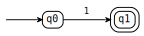

In [1]:
from tock import FiniteAutomaton
from tock.graphs import Graph, to_graph

basic_dfa: FiniteAutomaton = FiniteAutomaton()
basic_dfa.set_start_state("q0")
basic_dfa.add_accept_state("q1")
basic_dfa.add_transitions(["q0, 1 -> q1"])

graph: Graph = to_graph(basic_dfa)
display(graph)

The above finite automaton goes between two states: a start state (here, `"q0"`) and an accept state (here, `"q1"`, which is encircled twice). However, it only does so if the string it's processing begins with a `"1"`. In fact, this automaton represents the language `1`: only the string `"1"` is in that language. If `"1"` doesn't start the string or if it has other symbols following it, the string will be rejected by the automaton.

Hopefully, that has given you as sense of how to read an automaton. Now, we'll turn to those three operations that give regular expressions and finite automata their expressive power. 

### Alternation

In general, we like having options: options give us the ability to choose the outcome that's optimal for us. Our languages present options, too, in having many different ways to convey the same idea. Regular expressions come equipped with a mechanism to handle this phenomenon: (exclusive) alternation.

Alternation represents the logical idea of "exclusive or": one or another option can be chosen---but not both. In a regular expression, we use the symbol `∪` to provide two (or more) symbols as alternatives. For instance, the regular expression `0 ∪ 1` indicates the language containing strings `"0"` or `"1"`. We can model this via the finite automaton below: 

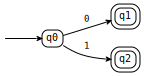

In [2]:
from tock import FiniteAutomaton
from tock.graphs import Graph, to_graph

alternation_dfa: FiniteAutomaton = FiniteAutomaton()
alternation_dfa.set_start_state("q0")
alternation_dfa.add_accept_state("q1")
alternation_dfa.add_accept_state("q2")
alternation_dfa.add_transitions([
	"q0, 0 -> q1",
	"q0, 1 -> q2"
])

graph: Graph = to_graph(alternation_dfa)
display(graph)

As we can see, the graph splits from the start state, `q0`, to two accept states, `q1` and `q2`. Each accept state has a distinct path, conditioned on the presence of either `"0"` or `"1"` at the beginning of the string, between the start state and itself.

 Our original positive number regular expression extensively uses alternation. We can see that the first digit is an alternation between all digits but 0, and the other digits are an alternation between every possible digit. We could similarly expand our finite automaton to represent these many alternatives.

### Concatenation

While we sometimes want options to choose from, at other times we want it all: we must pick every option. Languages also feature such requirements in their syntax. For instance, when using the word "and" in a complete sentence, we need at least two phrases to join with that word. We don't permit saying something like "I bought eggs and" or "I bought and milk"; indeed, only "I bought eggs and milk" maintains correct syntax.

Concatenation expresses the logical concept of "and". However, unlike the traditional logical operator of "and", as well as the "and" we use in everyday speech, the order of "and"'s conjuncts matters. In short, to a regular expression, saying "eggs and milk" is different from saying "milk and eggs", even though these phrases mean the same thing to us.

Concatenation is symbolized simply by placing symbols next to one another. For instance, if we wanted to accept the string `"10"`, then we would simply write the language `"10"`. Its automaton would be:

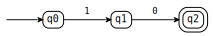

In [3]:
from tock import FiniteAutomaton
from tock.graphs import Graph, to_graph

concatenation_dfa: FiniteAutomaton = FiniteAutomaton()
concatenation_dfa.set_start_state("q0")
concatenation_dfa.add_accept_state("q2")
concatenation_dfa.add_transitions([
	"q0, 1 -> q1",
	"q1, 0 -> q2"
])

graph: Graph = to_graph(concatenation_dfa)
display(graph)

As this automaton displays, you need a string beginning with `"1"` and followed by `"0"` (with nothing else afterward) to reach the accept state, `q2`. Notably, we have a middle state here which is neither a start state nor an accept state; due to concatenation, we accumulate intermediate states that the automaton can be in as it is processing a string.

To revisit our positive number regular expression, we apply concatenation to join the first alternation between digits 1 through 9 `(1 ∪ 2 ∪ 3 ∪ 4 ∪ 5 ∪ 6 ∪ 7 ∪ 8 ∪ 9)` with the second alternation containing all digits `(0 ∪ 1 ∪ 2 ∪ 3 ∪ 4 ∪ 5 ∪ 6 ∪ 7 ∪ 8 ∪ 9)*`. As you can see, we can concatenate individual symbols as well as alternations between symbols, permitting a variety of symbolic combinations for our languages.

### Quantification

Like our other operators, quantification can be considered as a choice. However, instead of choosing between alternatives or conditioning choices on others, quantification indicates how many times a choice can be selected. 

In natural language, we see variable quantification with items in a series; both with "and" and "or", we could link as many conjuncts together as we wanted; we are only required to add the conjunction between the last two conjuncts. For instance, the sentences "I like the colors red and blue" is correct; so is "I like the colors red, green, and blue"; and so is "I like the colors red, purple, orange, yellow, black, green, white, and blue".

Regular expressions quantify an option by using the Kleene star, `*`, introduced by Stephen Kleene. This operator permits *zero or more* of a symbol or expression to be used. Consider the regular expression `1*`, depicted by the automaton below:

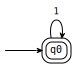

In [4]:
from tock import FiniteAutomaton
from tock.graphs import Graph, to_graph

quantification_dfa: FiniteAutomaton = FiniteAutomaton()
quantification_dfa.set_start_state("q0")
quantification_dfa.add_accept_state("q0")
quantification_dfa.add_transitions([
	"q0, 1 -> q0",
])

graph: Graph = to_graph(quantification_dfa)
display(graph)

Strings accepted by this automaton include `""` (the empty string) as well as `"1"`, `"1111"`, and `"1111111111"`, among others. A string of 100 `1`s would also be accepted! Any of these strings would result in our string returning to `q0`: as long as our string contained only `1`s, it would be accepted by this finite automaton.

Revisiting our positive number regular expression, the `*` is used in the second alternation. In other words, it allows for the selection of one of the nine digits zero or more times. With the concatenation of the initial digit before it, this results in a number at least one digit long and at most as many digits as desired. Moreover, because we are permitted to choose a different digit with each use of the Kleene star, the pattern permits any sequence of digits.

### Exercises

At this stage, we've seen all three operations for the original regular expressions: *alternation*, *concatenation*, and *quantification*. We've not only seen these operations independently within regular expression and finite automata, but we've also seen them work together to form any positive integer.

Let's do some recap! 

First, you'll tackle questions on the three operations that we discussed. Please note that one (and exactly one) option will be correct.

In [5]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["theory-alternation"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('ab', 'aa…

In [6]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["theory-concatenation"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('ε', 'abc…

In [7]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["theory-quantification"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('ε', 'a',…

Now that we've gone through the basics, let's reconsider our positive integer regular expression. The questions below will ask you to extend that expression to be more flexible using the three operations that you've learned.

Please note that, in the following questions, *at least* one answer will be correct. However, you will only need to select one answer. If you want, feel free to try and find all correct answers!

In [8]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["theory-negative-numbers"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('ε', '(-|…

In [9]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["theory-decimals"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('.(0 ∪ 1 …

Now that you've had some practice with regular expressions in theory, let's move on to the core of this notebook: doing regular expressions in practice.

## Regular Expressions: In Practice

The core intention of a regular expression is to supply a concise way to describe a set of strings. For instance, if we wanted to describe the set of valid times on a 24-hour clock, we'd rather write `(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])` than enumerate every possible time (all 1,440 of them). 

Each programming language defines its own way of writing regular expressions, although many of them employ similar notation and syntax. In this tutorial, we'll focus on Python, whose regular expression syntax is in turn based on Perl. 

Unlike their original theoretical counterparts, regular expressions in Python include syntactic sugar and additional mechanisms to make working with regular expressions easier. If you read the prior section, you likely noticed that the expression for times on a 24-hour clock is quite dissimilar to the formal notation. Similarly, to capture all positive numbers, we would write `[1-9][0-9]*` or even just `[1-9]\d*`.

Before we begin discussing Python's regular expression syntax, let's imagine a scenario where we might want to use a regular expression. You've probably made an account on a website where you've had to make a password with certain constraints. For example:
- ... it must have a certain number of characters. 
- ... it must include one capital letter and one lowercase letter.
- ... it must include at least one number.
- ... it must include at least one special character.
In our examples below, we'll model some of these constraints and restricted versions of others. These examples should also help to make sense of the clock times and the positive number regular expression given above.

One more aside before we begin: the code examples below will use a custom class, `RegexVerifier`, to display the results of applying regular expressions. This class hides away some details of applying regular expressions so that we can first focus on notation; then, in the next section, we'll examine the primitives of the `re` library. Furthermore, after you've read this notebook, feel free to examine the `regex_verifier.py` file for more details on how this class was constructed!

With all that said, we'll start off our journey in learning about Python's regular expressions by discussing three major operations they inherit from theoretical regular expressions: *alternation*, *concatenation*, and *quantification*.

### Alternation

Passwords are valuable as a way of protecting an account partially because we have choices. If we had a rather restrictive set of choices for a password, someone could try all options and eventually break into our accounts. (Indeed, even with large sets of options, brute force algorithms still attempt this on some websites!)

Python's regular expressions provide options through (exclusive) *alternation*, which is a formal term for the logical "XOR" or "exclusive or" operator. Python uses two main kinds of notation to express alternation.
- The first kind of alternation, referred to here as *bar alteration*, which is the most basic and most flexible, employs the `|` operator.
- The second kind of alternation, referred to here as *bracket alternation*, uses square brackets; that is, it surrounds characters with `[` and `]`.

To understand how each of these work, let's see them in action. Suppose that we want our passwords to end with a specific digit, such as `"0"` or `"1"`. Then, we could write any of the following regular expressions:

In [10]:
from utils.widgets.regex_verifier import RegexVerifier

first_pattern: str = "0|1"
second_pattern: str = "[01]"
patterns: list[str] = [first_pattern, second_pattern]
strings: list[str] = ["", "0", "1", "01", "10"]

for alternation_pattern in patterns:
	for alternation_string in strings:
		RegexVerifier.apply_regex(alternation_pattern, alternation_string)
	else:
		print("-" * 100)   # Permits break between use of each pattern.

Regular expression "0|1" does not match string "".
Regular expression "0|1" matches "0".
Regular expression "0|1" matches "1".
Regular expression "0|1" does not match string "01".
Regular expression "0|1" does not match string "10".
----------------------------------------------------------------------------------------------------
Regular expression "[01]" does not match string "".
Regular expression "[01]" matches "0".
Regular expression "[01]" matches "1".
Regular expression "[01]" does not match string "01".
Regular expression "[01]" does not match string "10".
----------------------------------------------------------------------------------------------------


The above example proposes two patterns--one for each variant of alternation. Each pattern matches *either* the symbol `"0"` or the symbol `"1"`. Both symbols together, however, will not be matched; similarly, the empty string will not be matched.

We could also add further options to both. For example, suppose that we wanted to add the digit `"2"`. Then:

In [11]:
from utils.widgets.regex_verifier import RegexVerifier

first_pattern: str = "0|1|2"
second_pattern: str = "[012]"
patterns: list[str] = [first_pattern, second_pattern]
strings: list[str] = ["0", "1", "2"]

for alternation_pattern in patterns:
	for alternation_string in strings:
		RegexVerifier.apply_regex(alternation_pattern, alternation_string)
	else:
		print("-" * 100)   # Permits break between use of each pattern.

Regular expression "0|1|2" matches "0".
Regular expression "0|1|2" matches "1".
Regular expression "0|1|2" matches "2".
----------------------------------------------------------------------------------------------------
Regular expression "[012]" matches "0".
Regular expression "[012]" matches "1".
Regular expression "[012]" matches "2".
----------------------------------------------------------------------------------------------------


As we can see, the addition of a new symbol can be done easily in both kinds of alternation. For the former, a new `|` needs to be added for each option in alternation; for the latter, the character simply needs to be incorporated into the square brackets.

Python provides a convenient shorthand for ordered sets of characters in bracket notation. For instance, digits are ordered from 0 to 9. As a result, instead of writing `[012]`, we could write `[0-2]` (or `[0-9]` for all digits). For alphabetical characters, we could do this as well: `[a-z]` and `[A-Z]` represent the sets of lowercase and uppercase characters, respectively. 

We'll see later that bar and bracket alternation aren't *exactly* equivalent, but both permit selecting one among different symbol options.

Python can also apply a third sort of alternation. This sort is much less flexible than the other two. It uses special notation or escaped characters as shortcuts to sets of characters that you could manually define with the other two methods. Here are some examples:
- ".": the set of all symbols.
- `"\d"`: the set of all numerical digits (*i.e.*, `"0"`, `"1"`, `"2"`, and so on).
- `"\s"`: the set of all whitespace characters, here defined as the space (`" "`), the newline character (`"\n"`), the carriage return (`"\r"`), the form-feed character (`"\f"`), and the vertical tab character (`"\v"`).
- `"\w"`: the set of all *word* characters. The definition of "word" depends on whether the text encoding of the regular expression is considered ASCII or Unicode. If it is the former, then all uppercase characters, all lowercase characters, all digits, and the underscore are included; if it is the latter, a larger set of characters are included. For ease of use, you might consider this to be a near-opposite to `"\s"`. Python's string function `.isalnum()` only returns `True` if all characters are word characters, so it can be used to differentiate word and non-word characters.

Other important examples of alternation shortcuts are *inverses* of those presented above. In other words, there is also a `"\D"`, `"\S"`, and `"\W"` which represent all characters *not* in `"\d"`, `"\s"`, and `"\w"`, respectively. (Note that the empty string is ***not*** included in the inversion.)

We can also invert a custom set of characters for alternation, but we can only do so with the *second* alternation notation. To do this, we use the special character `^` after the left bracket. For instance, we could manually write `"\D"`, the inversion of `"\d"`, like this: `"[^0123456789]"`. The code below gives some evidence for their equivalence:

In [12]:
from utils.widgets.regex_verifier import RegexVerifier

first_pattern: str = "\D"
second_pattern: str = "[^0123456789]"
patterns: list[str] = [first_pattern, second_pattern]
strings: list[str] = ["", "0", "1", "a"]

for alternation_pattern in patterns:
	for alternation_string in strings:
		RegexVerifier.apply_regex(alternation_pattern, alternation_string)
	else:
		print("-" * 100)   # Permits break between use of each pattern.

Regular expression "\D" does not match string "".
Regular expression "\D" does not match string "0".
Regular expression "\D" does not match string "1".
Regular expression "\D" matches "a".
----------------------------------------------------------------------------------------------------
Regular expression "[^0123456789]" does not match string "".
Regular expression "[^0123456789]" does not match string "0".
Regular expression "[^0123456789]" does not match string "1".
Regular expression "[^0123456789]" matches "a".
----------------------------------------------------------------------------------------------------


To sum up this subsection, Python provides us with many options for displaying our options. On the one hand, as we'll see in a later subsection (see "Concatenation" and "Grouping"), bar alternation is a more powerful, if more verbose, notation; on the other hand, bracket notation has a lot of syntactic sugar baked into it that makes it easy to use for selecting from a single set of symbols.

Before moving on, feel free to try the exercises below to check your understanding.

#### Exercises

In [13]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["password-special-character"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('~|!|@|#'…

In [14]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["password-single-digit"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('\\d', '[…

### Concatenation

With alternation, we discussed how options permitted us to provide a stronger password. Of course, having one choice to make will only get us so far; on the other hand, if we join multiple choices together, we vastly expand our options for passwords! 

Python's regular expressions allow us to order and join multiple items together through *concatenation*, which is equivalent to an ordered version of the logical "AND" operation. The manner in which we do this in Python's syntax is quite simple: we simply place each item next to the other one. Of course, since space characters are also valid characters to match, we mean that items should be *directly* adjacent with no intervening characters.

Let's see this in action with an example. Suppose that, in our password, we want the following items:
1. A capital letter,
2. a lowercase letter,
3. a numerical digit, and
4. a special character.

We'll assume that we want these items in the order presented. Let's consider each choice in turn.
1. First, we need to pick a capital letter. From the last section, we saw that `[A-Z]` is the set of all capital letters.
2. Second, we need to pick a lowercase letter. We similarly saw in the last section that `[a-z]` is the set of all lowercase letters.
3. Third, we need to pick a numerical digit. Since there's a shortcut for the set of numerical digits, we'll use that: `\d`.
4. Finally, we want the set of special characters. Unfortunately, there's not a convenient shortcut for all special characters. For our purposes, we'll limit our special characters to the set discussed in the previous section: `"~"`, `"!"`, and `"@"`.

In [15]:
from utils.widgets.regex_verifier import RegexVerifier

capital_letter_item: str = "[A-Z]"
lowercase_letter_item: str = "[a-z]"
numerical_digit_item: str = "\d"
special_character_item: str = "[~!@]"
concatenation_pattern: str = capital_letter_item + lowercase_letter_item + numerical_digit_item + special_character_item

strings: list[str] = [
	"",
	"A",
	"Aa",
	"Aa0",
	"Aa0~",
	"Aa0~B",
	"~0aA"
]

for concatenation_string in strings:
	RegexVerifier.apply_regex(concatenation_pattern, concatenation_string)

Regular expression "[A-Z][a-z]\d[~!@]" does not match string "".
Regular expression "[A-Z][a-z]\d[~!@]" does not match string "A".
Regular expression "[A-Z][a-z]\d[~!@]" does not match string "Aa".
Regular expression "[A-Z][a-z]\d[~!@]" does not match string "Aa0".
Regular expression "[A-Z][a-z]\d[~!@]" matches "Aa0~".
Regular expression "[A-Z][a-z]\d[~!@]" does not match string "Aa0~B".
Regular expression "[A-Z][a-z]\d[~!@]" does not match string "~0aA".


From the results of applying our regular expression to the given set of strings, we can see that only a password with four symbols in the order of capital letter, lowercase letter, numerical digit, and special character derives a match. The empty string (`""`), partial matches (*e.g.*, `"Aa0"`), extensions (*e.g.*, `"Aa0~B"`), and reorderings (*e.g.*, `"~0aA"`) will not work. In this way, concatenation is restrictive: it specifies both the type and position of symbols.

You might notice that our example above used bracket alternation and shortcuts in its regular expression; what about bar alternation? We can also concatenate bar alternation, but we can't just swap, say, `[~!@]` for `~|!|@`. This is because we need to distinguish between an option in bar notation, which in itself could be a concatenation of symbols, and a new symbol.

Let's see an example. Say that we wanted to process a document and gather answers from a survey to "Yes" or "No" questions. We could use a regular expression to match exactly these options:

In [16]:
from utils.widgets.regex_verifier import RegexVerifier

concatenation_pattern: str = "Yes|No"

strings: list[str] = [
	"",
	"Y",
	"N",
	"Yes",
	"No",
	"Maybe",
	"Don't Know"
]

for concatenation_string in strings:
	RegexVerifier.apply_regex(concatenation_pattern, concatenation_string)

Regular expression "Yes|No" does not match string "".
Regular expression "Yes|No" does not match string "Y".
Regular expression "Yes|No" does not match string "N".
Regular expression "Yes|No" matches "Yes".
Regular expression "Yes|No" matches "No".
Regular expression "Yes|No" does not match string "Maybe".
Regular expression "Yes|No" does not match string "Don't Know".


We can see that this regular expression matches only the concatenated options `"Yes"` and `"No"`--not shortened forms (`"Y"`, `"N"`). In short, unlike bracket alternation, bar alternation can consist of more complex alternatives. We'll expand on this further in a later section (see Grouping).

To summarize, we've now gotten a sense of *concatenation* in regular expressions. Concatenation joins items together in a specified order, and Python's syntax allows for this simply by appending each portion of a pattern to the next.

To check your understanding, feel free to try out the exercises below!

#### Exercises

In [17]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["password-three-two-one"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('[a-zA-Z]…

In [18]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["survey-options"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('[Strongl…

### Quantification

So far, we've been able to pick between a variety of options (alternation) and combine them together in a specified order (concatenation). With these mechanisms, we can create passwords of decent complexity. However, even with choice, this manner of password requires a rigid templatic structure. This is disadvantageous in two ways:
1. First, it retains security issues. Our current operators do not permit any variation in the number of symbols: each alternation ultimately results in one symbol, and we must specify the number of and order of the alternations that must be satisfied. As a result, if someone were to figure out that a password must be a certain number of characters, they could vastly diminish the search space for passwords.
2. Second, it is tedious to write; we must specify the number of permitted characters *exactly*, as we have no way of making some items optional or able to be used repeatedly.

Thankfully, both the original regular expressions and Python's implementation of them implement a third operator to solve this problem: *quantification*. In fact, the original formalism and Python use the same symbol to represent quantification: `*`. Both append this symbol after the alternation that they modify, permitting the use of *zero or more* of items in that alternation.

Let's consider some examples of quantification. 

Before we move back to our password example, let's start off with a simple one. As you may know, all data in a computer is stored as bits, commonly referred to as `0`s and `1`s. We can form the space of all possible bit strings as follows: `[01]*`. We can see the variety of this strings that this accepts below:

In [19]:
from utils.widgets.regex_verifier import RegexVerifier

quantification_pattern: str = r"[01]*"

strings: list[str] = [
	"",
	"0",
	"1",
	"01",
	"10",
	"1010",
	"1100110"
]

for quantification_string in strings:
    RegexVerifier.apply_regex(quantification_pattern, quantification_string)

Regular expression "[01]*" matches "".
Regular expression "[01]*" matches "0".
Regular expression "[01]*" matches "1".
Regular expression "[01]*" matches "01".
Regular expression "[01]*" matches "10".
Regular expression "[01]*" matches "1010".
Regular expression "[01]*" matches "1100110".


As you can see, any combination of `"0"` and `"1"` is matched by this regular expression. This also includes the empty string, as `""` is the result of combining zero `"0"`s and zero `"1"`s.

While affording quite a bit of flexibility, there's some inconvenience to including the empty string; we often want to match *something* rather than *nothing*. Indeed, it doesn't really make sense to have an empty string of bits. We could resolve this by writing `"[01][01]*"`, guaranteeing that there will always be at least one bit. 

However, common practices of writing regular expressions have led to additional syntax that handles this case for us. Instead of writing `*`, we write `+` to mean *one or more* of the items in an alternation. In other words, we could write `"[01][01]*"` more simply as `"[01]+"`. When we do that:

In [20]:
from utils.widgets.regex_verifier import RegexVerifier

quantification_pattern: str = r"[01]+"

strings: list[str] = [
	"",
	"0",
	"1",
	"01",
	"10",
	"1010",
	"1100110"
]

for quantification_string in strings:
    RegexVerifier.apply_regex(quantification_pattern, quantification_string)

Regular expression "[01]+" does not match string "".
Regular expression "[01]+" matches "0".
Regular expression "[01]+" matches "1".
Regular expression "[01]+" matches "01".
Regular expression "[01]+" matches "10".
Regular expression "[01]+" matches "1010".
Regular expression "[01]+" matches "1100110".


Now, with the introduction of the `+`, we no longer match the empty string.

Let's turn back to our password scenario. Suppose that we have the following constraints on our password:
1. Optionally, the password may begin with a capital letter. There is no strict upper limit on the number of uppercase letters.
2. After the (optional) capital letters, the password must contain at least one lowercase letter. There is no strict upper limit on the number of lowercase letters.
3. The password must contain between two and four numerical digits.
4. The password must contain at most one special character of `"~"`, `"!"`, or `"@"`.

We'll consider each of these constraints in turn.

First, we saw in previous sections that the set of all capital letters is `[A-Z]`. Because the constraint on the number of capital letters can be interpreted as "zero or more", we can reflect this constraint as: `[A-Z]*`.

Second, in a similar manner, we might recall that the set of all lowercase letters is `[a-z]`. We require at least one lowercase letter in this constraint, but we are otherwise unconstrained. As a result, to reflect this "one or more" constraint, we could write: `[a-z]+`.


Third, we return to our shortcut for the set of digits: `\d`. In this case, our constraint is more complex; we need *at least* two and *at most* four digits. We've seen already how to fulfill the *at least* condition: we could append as many alternations as we wanted with one another. However, with our current syntax, we have no way of making an alternation optional while limiting the number of times it can be used. In other words, thus far, the upper limit has always been unbounded.

In cases like this, Python provides a generic syntax to determine the number of times that an alternation should be selected to form a match. This syntax takes the form: `{m,n}`, where `m` and `n` are the lower bound and upper bound on the number of repetitions, respectively. 

For our password example, the *minimum* number of times that the repetition can occur (`m`) is 2. The *maximum* number of times that the repetition can occur (`n`) is 4. Therefore, to model this constraint, we could write: `\d{2,4}`.

Before we move on to the final constraint, let's see this one in action:

In [21]:
from utils.widgets.regex_verifier import RegexVerifier

quantification_pattern: str = r"\d{2,4}"

strings: list[str] = [
	"1",
	"12",
	"123",
	"1234",
	"12345",
]

for quantification_string in strings:
    RegexVerifier.apply_regex(quantification_pattern, quantification_string)

Regular expression "\d{2,4}" does not match string "1".
Regular expression "\d{2,4}" matches "12".
Regular expression "\d{2,4}" matches "123".
Regular expression "\d{2,4}" matches "1234".
Regular expression "\d{2,4}" does not match string "12345".


We can see that this syntax meets the desired constraints. Numbers with two, three, or four digits are all allowed, whereas those with less or more are not.

Fourth, we need to have *at most* one of our special character set, `[~!@]`. Our `*` and `+` special characters won't help us here, as they set lower bounds. However, our more generic operator, `{m,n}` can.

Since we need *at least* zero and *at most* one special character, we could write: `[~!@]{0,1}`. However, `0` is not really a true bound: we can't have negative characters, so `0` is the default value. As a result, we could also write: `[~!@]{,1}`. In other words, we can omit either `m` or `n` (but not both) to exhibit that the minimum or maximum number of characters is unbounded.

As it turns out, there is also a *third* way to write this expression. Because our bounds are `0` and `1`, we can also use the special character `?`. This character is equivalent to `{0,1}` and `{,1}`, expressing that its attached alternation is either present once or absent altogether.

We'll now take a look at these special characters in practice. The below shows that each of the patterns accepts and rejects the same strings:

In [22]:
from utils.widgets.regex_verifier import RegexVerifier

first_pattern: str = "[~!@]{0,1}"
second_pattern: str = "[~!@]{,1}"
third_pattern: str = "[~!@]?"
patterns: list[str] = [first_pattern, second_pattern, third_pattern]
strings: list[str] = [
	"",
	"~",
	"!!",
]

for quantification_pattern in patterns:
	for quantification_string in strings:
		RegexVerifier.apply_regex(quantification_pattern, quantification_string)
	else:
		print("-" * 100)   # Permits break between use of each pattern.

Regular expression "[~!@]{0,1}" matches "".
Regular expression "[~!@]{0,1}" matches "~".
Regular expression "[~!@]{0,1}" does not match string "!!".
----------------------------------------------------------------------------------------------------
Regular expression "[~!@]{,1}" matches "".
Regular expression "[~!@]{,1}" matches "~".
Regular expression "[~!@]{,1}" does not match string "!!".
----------------------------------------------------------------------------------------------------
Regular expression "[~!@]?" matches "".
Regular expression "[~!@]?" matches "~".
Regular expression "[~!@]?" does not match string "!!".
----------------------------------------------------------------------------------------------------


With each component of our password properly constrained, we can now filter out invalid passwords that don't meet our criteria. Let's examine the result of our work in the code below.

In [23]:
from utils.widgets.regex_verifier import RegexVerifier

capital_letter_item: str = "[A-Z]*"
lowercase_letter_item: str = "[a-z]+"
numerical_digit_item: str = "\d{2,4}"
special_character_item: str = "[~!@]?"
quantification_pattern: str = capital_letter_item + lowercase_letter_item + numerical_digit_item + special_character_item

strings: list[str] = [
	"Password123@",
	"password123@",
	"PASSword123@",
	"PASSWORD123@",
	"Password1@",
	"Password12345@",
	"Password123~!@",
	"Password123"
]

for quantification_string in strings:
	RegexVerifier.apply_regex(quantification_pattern, quantification_string)

Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" matches "Password123@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" matches "password123@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" matches "PASSword123@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" does not match string "PASSWORD123@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" does not match string "Password1@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" does not match string "Password12345@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" does not match string "Password123~!@".
Regular expression "[A-Z]*[a-z]+\d{2,4}[~!@]?" matches "Password123".


Of the eight potential passwords, four meet our requirements and four do not. Although there's a lot we could say about these eight examples in aggregate, we'll summarize the main takeaways here:
- Passwords 1, 2, and 3 show that initial capital letters are possible but not required.
- Passwords 3 and 4 show that at least one lowercase letter is required; the omission of the lowercase letter in the fourth password causes its rejection.
- Passwords 5 and 6 show the effectiveness of our digit constraint, as 1 and 5 digits are not within the instituted 2-4 digit range.
- Passwords 7 and 8, when contrasted against the other accepted passwords, exhibit that up to one special character is permitted. Having no special characters is also valid.

With that covered, we've now seen the variety of ways in which Python implements quantification in regular expressions. Feel free to check your understanding of quantification with the exercises below.

#### Exercises

In [24]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["practical-negative-numbers"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('-[1-9]\\…

In [25]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["practical-decimals"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('[1-9]\\d…

### Grouping

So far, we've introduced three powerful features boasted by Python's regular expressions. However, these features still have limitations. For now, we'll turn our attention away from the recurrent password example to examine three cases where these limitations are more pronounced.

#### Problem 1: Complex Quantification

Previously, you saw that we could model bit strings with the regular expression `[01]+`. However, what if we wanted to model *bytes*? We define a byte as a sequence of eight bits. It cannot be seven or nine bits--it must be exactly eight bits.

Let's start by modeling a byte. We've been given a constraint of exactly *eight* repetitions of our alternation. Thus, for this, we'd write `[01]{8,8}`. As the code block below displays, this does exactly what we'd want:


In [26]:
from utils.widgets.regex_verifier import RegexVerifier

grouping_pattern: str = r"[01]{8,8}"
strings: list[str] = [
	"1111000",
	"11110000",
	"111100000"
]

for grouping_string in strings:
    RegexVerifier.apply_regex(grouping_pattern, grouping_string, show_groups=True)

Regular expression "[01]{8,8}" does not match string "1111000".
Regular expression "[01]{8,8}" matches "11110000".
Regular expression "[01]{8,8}" does not match string "111100000".


Problems arise when we consider that we can't just model a single *byte*. Rather, we want to gather entire sequences of bytes. If we assume that these byte sequences must be perfect multiples of 8, our quantification notation becomes insufficient. For instance, `[01]{8,24}` might model sequences of one, two, and three bytes, but it will also include incomplete bytes. 

#### Problem 2: Ambiguous Modification

This problem with more complex patterns of quantification extends to other scenarios involving concatenation, as well. Suppose that we wanted to collect sentences which contain a series of at least three nouns; in other words, some variation on "X, Y, and Z" or "X, Y, or Z". For simplicity, let's make the following assumptions: all nouns have no adjectives modifying them; all series do not begin a sentence; all series employ the Oxford comma. 

To capture this list of items, we know that each non-final item in the series is going to look like ` \w+,`, where `\w` is our word-character shortcut. Meanwhile, the final item will be ` or \w+` or ` and \w+`. We could then capture these options in a bar alternation: ` \w+,| or \w+| and \w+`.

However, from our discussions of alternation, you might recall that we can only select *one* option with any alternation. Ideally, then, we would use quantification to select from our three presented options: for example, we would append a `{3,}` to indicate that we want a series of at least three items. but we are foiled here, too. Our quantification notation may be able to attach to bracket notation, but we currently have no way of saying that we are repeating the *entire* bar alternation as opposed to the last character. 

#### Problem 3: The Tedium of Possibilities

A third problem we can't solve has less to do with patterns we can't make and more to do with the writability of such patterns. When possible, regular expressions shouldn't require us to write out more than necessary to represent the strings that we want to match. However, when we get more complex chains of concatenation and alternation, we end up doing exactly that.

One of our prior exercises discussed survey questions on a Likert scale with five options. Let's suppose here that we have further options for finer granularity. For example, a review for a service might ask you to choose how you felt about that service and provide the following alternatives: "Very Dissatisfied", "Moderately Dissatisfied", "Slightly Dissatisfied", "Neutral", "Slightly Satisfied", "Moderately Satisfied", "Very Satisfied". One valid way of modeling this in a regular expression is as follows: `Very Dissatisfied|Moderately Dissatisfied|Slightly Dissatisfied|Neutral|Slightly Satisfied|Moderately Satisfied|Very Satisfied`. 

You might notice that there's a lot of redundancy in this expression: `"Dissatisfied"` and `"Satisfied"` occur in three items, whereas `"Very"`, `"Moderately"`, and `"Slightly"` occur in two. In the most abbreviated form, we might select either `"Neutral"` or between one of `"Very"`, `"Moderately"`, and `"Slightly"`, and subsequently between one of `"Dissatisfied"` and `"Satisfied"`. However, we currently have no way of *nesting* bar alternation to model this; as a result, our only option is to write everything out. You can imagine process getting increasingly tedious as a regular expression accrues more sources of alternation.

#### The Solution

Thankfully for us, each of the three problems above has one solution: *groups*. Grouping is a powerful concept in Python's regular expression notation. In effect, it permits us to combine a series of alternations together into a unit and modify that unit altogether.

Thus far, we've used square brackets for alternation and curly brackets for quantification. You might've noticed that we skipped over regular parentheses; well, this is where they come in! To denote a group in a regular expression, we wrap that group in parentheses. For instance, `([01])` is a group containing a single alternation. We can fit any number of items inside a group.

Let's solve each of the problems above by using groups.

We'll start with the first. If we want to capture only strings of bytes, then we need to capture units that are multiples of eight. When we group our byte string of length 8, we then can repeatedly gather that group of eight like so: `([01]{8,8})+`. In other words, we gather at least *one* group of eight bits, and we can do so as many times as we need.

Let's see this in action.

In [27]:
from utils.widgets.regex_verifier import RegexVerifier

grouping_pattern: str = r"([01]{8,8})+"
strings: list[str] = [
	"1111000",   # seven digits
	"11110000",   # eight digits
	"111100000",   # nine digits
	"111100001111000",   # fifteen digits
	"1111000011110000",   # sixteen digits
	"11110000111100000"   # seventeen digits
]

for grouping_string in strings:
    RegexVerifier.apply_regex(grouping_pattern, grouping_string)

Regular expression "([01]{8,8})+" does not match string "1111000".
Regular expression "([01]{8,8})+" matches "11110000".
Regular expression "([01]{8,8})+" does not match string "111100000".
Regular expression "([01]{8,8})+" does not match string "111100001111000".
Regular expression "([01]{8,8})+" matches "1111000011110000".
Regular expression "([01]{8,8})+" does not match string "11110000111100000".


As we can see, this regular expression does the trick: it matches the strings with eight and sixteen bits, and it does not match any strings with incomplete bytes. Here, groups provide us with a convenient way of applying quantifiers to a *sequence* of alternations rather than individual ones.

Given the above solution, you might already see how we'll solve our second problem in finding a series.

Let's suppose that we capture any beginning and ending of a sentence with `.*` Then, we turn to our series expression. As stated, we want to capture our items in a series at least three times before we match the sentence. Then, we'll need to apply the quantifier `{3,}` to our series expression: `( \w+,| or \w+| and \w+){3,}`.

However, this is actually too permissive! Since we are treating these three items as alternatives, we could select the ` or \w+` or ` and \w+` options in a non-final position. Let's move this pair of options outside the alternation to reflect this. We also should the number of alternations accordingly to reflect that one of these must be final. This results in: `( \w+,){2,}( or \w+| and \w+)`.

With the power of groups, we can abbreviate this notation further. You might've noticed that our `or` and `and` options only swap their conjunction and nothing else. Since everything else is the same, we can rewrite the second group to reflect the actual alternation taking place: `( \w+,){2,} (and|or) \w+`.

This final regular expression looks quite a bit more like what you'd see in a sentence. Not only does it do what we'd want, but it's also more readable and writable!

Let's illustrate that it's functioning properly in the following code block.

In [28]:
from utils.widgets.regex_verifier import RegexVerifier

grouping_pattern: str = r".+( \w+,){2,} (and|or) \w+.*"
strings: list[str] = [
	"My favorite color is red.", 
	"My favorite colors are red and blue.",
	"My favorite colors are red, purple, and blue.",
	"My favorite color is red, purple, or blue.",
	"My favorite colors are red, orange, purple, and blue.",
	"My favorite colors are red and blue, but I don't like green or yellow.",
	"My favorite color is red, purple, or blue, but I don't like green or yellow."
]

for grouping_string in strings:
    RegexVerifier.apply_regex(grouping_pattern, grouping_string)

Regular expression ".+( \w+,){2,} (and|or) \w+.*" does not match string "My favorite color is red.".
Regular expression ".+( \w+,){2,} (and|or) \w+.*" does not match string "My favorite colors are red and blue.".
Regular expression ".+( \w+,){2,} (and|or) \w+.*" matches "My favorite colors are red, purple, and blue.".
Regular expression ".+( \w+,){2,} (and|or) \w+.*" matches "My favorite color is red, purple, or blue.".
Regular expression ".+( \w+,){2,} (and|or) \w+.*" matches "My favorite colors are red, orange, purple, and blue.".
Regular expression ".+( \w+,){2,} (and|or) \w+.*" does not match string "My favorite colors are red and blue, but I don't like green or yellow.".
Regular expression ".+( \w+,){2,} (and|or) \w+.*" matches "My favorite color is red, purple, or blue, but I don't like green or yellow.".


Our regular expression evidently meets our requirements. It only matches those strings with a series of at least three items (*i.e.*, #3, #4, #5, and #7)---including ones with multiple potential series (*i.e.*, #7). With this example, we've seen how groups can permit more complex sequences of alternations.

Based on our use of groups in the last example, you might be able to imagine how groups can be used to improve writability. For our seven-item Likert scale, we'll start where we stopped. The regular expression `Very Dissatisfied|Moderately Dissatisfied|Slightly Dissatisfied|Neutral|Slightly Satisfied|Moderately Satisfied|Very Satisfied` initially contains seven alternatives.

The strings `"Satisfied"` and `"Dissatisfied"` are both paired with each of `"Very"`, `"Moderately"`, and `"Slightly"`. Meanwhile, `"Neutral"` has no relation to these patterns. In short, if we have an item that is either `"Satisfied"` or `"Dissatisfied"`, we have to choose both the adjective and adverb modifying it.

Since there are two choices, we can represent the `"Satisfied"` and `"Dissatisfied"` variations with two alternations. For them, we can write: `(Very|Moderately|Slightly) (Satisfied|Dissatisfied)`. To this, we can join the `Neutral` option on its own. However, we have to be careful about our grouping; if we wrote `(Satisfied|Dissatisfied)|Neutral`, we would be making a three-way alternation with extra parentheses. 

Because `"Neutral"` isn't modified at all, we can nest the two alternations in a larger group and alternate `"Neutral"` with that to properly match all our options. This would result in the expression `((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral`.

We test this expression in the block below.

In [29]:
from utils.widgets.regex_verifier import RegexVerifier

grouping_pattern: str = "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral"
strings: list[str] = [
	"Very Satisfied",
	"Moderately Satisfied",
	"Slightly Satisfied",
	"Neutral",
	"Very Neutral",
	"Slightly Dissatisfied",
	"Moderately Dissatisfied",
	"Very Dissatisfied",
]

for grouping_string in strings:
    RegexVerifier.apply_regex(grouping_pattern, grouping_string)

Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Very Satisfied".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Moderately Satisfied".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Slightly Satisfied".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Neutral".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" does not match string "Very Neutral".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Slightly Dissatisfied".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Moderately Dissatisfied".
Regular expression "((Very|Moderately|Slightly) (Satisfied|Dissatisfied))|Neutral" matches "Very Dissatisfied".


You'll see here that all of our Likert scale options match. Moreover, due to our careful grouping, the combined "Very Neutral" string is not matched, as "Very" has no way of combining with "Neutral". This use of grouping displays its ability to write regular expressions more succinctly.  

As it turns out, this isn't all groups have to offer; in fact, there's a load of additional syntax that permits an extensive use of groups. While we won't address it all in this notebook, we'll touch on a few handy constructions that Python supports.

#### Specialized Groups

Throughout our examples this far, we've shown how regular expressions are powerful pattern-matching tools. We've seen many uses of these patterns for selecting and filtering data points. In some applications, however, we don't just want to match a pattern; we want specific pieces of information *inside* that pattern.

In Python's `re` module, groups aren't just a useful feature in regular expressions. They can also be captured by the module and are accessible through its API. 

By default, groups are *capturing* groups: the library will keep track of what portion of a string is matched by each group in a regular expression. Python's regular expression syntax allows us to create *non-capturing* groups, as well. If we know that some of the string isn't important to us, we can use groups to discard the information that doesn't matter and extract the information that does.

Any specialized group in Python is introduced by placing the `?` character after the first parenthesis of the group. We specify the type of group with further characters. As an example, let's briefly examine non-capturing groups. These groups join `?` with a `:` symbol. In other words, a non-capturing group might look like: `(?:<expression>)`, where `<expression>` is replaced with any subexpression of choice. 

These groups are useful when we might functionally need a group in our regular expression, but we don't actually need that group's matching text to be saved. For instance, in our Likert scale example, if we wanted to boil down our set of seven categories to three, we could adjust our groups to the following expression: `((?:(?:Very|Moderately|Slightly) (?:Satisfied|Dissatisfied))|Neutral)`. Then, instead of checking the match directly for each string, we'd examine Group 1 of the returned object to determine whether the matched categorization was, in general, `"Satisfied"`, `"Dissatisfied"`, or `"Neutral"`. We'll see how to do this in the following section.

Another highly useful type of group augments capturing groups to have names. By default, all groups have numbers. The whole match is Group 0; then, each subsequent capturing group inside the regular expression obtains higher group number (*e.g.*, the outermost group for the prior regular expression). However, we can also use Python's regular expression API to access groups by name. Names help to make our regular expressions more readable and also assist in unambiguously accessing the values that we want.

It's been a little while, so you might not remember--but we've actually seen named groups before! At the very beginning of this section, we gave a regular expression to identify times on a 24-hour clock: `(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])` .

You can see from this expression a new symbol and notation to show names. To indicate that we are using a named group, we follow up the `?` symbol with a `P`. Then, in triangular brackets, we write the name of our group. Names *must* be unique in a regular expression; otherwise, there are few constraints on them.

We've talked a bit about numbered and named groups, but let's take a peek at some examples.

In [30]:
from utils.widgets.regex_verifier import RegexVerifier

grouping_pattern: str = "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])"
strings: list[str] = [
	"00:01",
	"06:30",
	"12:45",
	"23:59"
]

for grouping_string in strings:
	RegexVerifier.apply_regex(grouping_pattern, grouping_string, show_groups=True)
	RegexVerifier.apply_regex(grouping_pattern, grouping_string, show_named_groups=True)
	print("-" * 100)

Regular expression "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])" matches "00:01".
	Group 1: "00"
	Group 2: "01"
Regular expression "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])" matches "00:01".
	Group "hour": "00"
	Group "minute": "01"
----------------------------------------------------------------------------------------------------
Regular expression "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])" matches "06:30".
	Group 1: "06"
	Group 2: "30"
Regular expression "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])" matches "06:30".
	Group "hour": "06"
	Group "minute": "30"
----------------------------------------------------------------------------------------------------
Regular expression "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])" matches "12:45".
	Group 1: "12"
	Group 2: "45"
Regular expression "(?P<hour>[01][0-9]|[2][0-3]):(?P<minute>[0-5][0-9])" matches "12:45".
	Group "hour": "12"
	Group "minute": "45"
------------------------------------------

The above displays our two *subgroups* of the expression above. To Python, a regular expression matches one big group; in turn, the groups that we define are portions of that group. That's why our groups are at indices 1 and 2 rather than index 0. To focus on the subgroups, we only display those here---although the entire group is also accessible at index 0.

For all four of our valid times, each match is what we'd expect: we get the pair of hours digits in the former subgroup and the pair of minutes digits in the latter subgroup. Indices and names align exactly, permitting us multiple ways of accessing parts of our matched strings.

With all that said, we've covered the basics of groups in Python. You've seen the ways in which groups interact with the three basic operations of regular expressions; you've been introduced to capturing and non-capturing groups; and you've seen how named capturing groups can be expressed to enhance readability in writing and applying regular expressions.

Before moving on to our final (and short) subsection, feel welcome to check your understanding with the exercises below!

#### Exercises

In [31]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["hexadecimals"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('[0-9A-F]…

In [32]:
from utils.activities.question_table import QUESTION_TABLE

display(QUESTION_TABLE["dates"])

MultipleChoiceQuestion(children=(Output(), RadioButtons(layout=Layout(width='max-content'), options=('None; th…

### Other Crystals of Syntactic Sugar

At this stage, we've covered four major operations in Python's regular expressions: alternation, concatenation, quantification, and grouping. That's not all there is, though: there are quite a few more bits of notation that you can use to specialize your regular expressions. Some increase the language-recognizing power that regular expressions have even further.

Just so you're aware of them, we'll briefly discuss a few below. We'll also specify some of the Python versions where they were added--as some of them were quite recent additions! For more information on these techniques, please refer to Python's documentation.

Without further ado, let's take a look at these features. 

**Positional Characters**. Although we use concatenation to indicate where characters are relative to one another, we haven't yet provided a way to determine where the match is relative to the string being matched. Python provides two operators to indicate position: `^` for the beginning of the string and `$` for the end of the string. In other words, these positional operators state that the characters adjacent to them must be at the beginning or end of the string, respectively.

**Flags**. Groups have a variety of *flags* that can be applied to them. These were added in Python 3.6. In groups, they are placed after the `?` and before a `:`, as they tend to be non-matching groups that define the behavior of the subexpressions they contain. They can restrict matching to ASCII characters or expand it to Unicode characters, ignore letter casing, extend matches across line breaks, and more.

**Lookahead and Lookbehind**. Regular non-capturing groups don't impact the overall string matched. However, since Python some group notation can be used to provide constraints on a string being matched that include information at one side or another in a string. For text preceding the string, we use a *lookbehind group*; for text following the string, we use a *lookahead group*. 

These groups require their contained subexpression to be matched for the whole expression to be matched, but they are not captured in the final result. We can also employ *negative lookahead* and *negative lookbehind* groups; these groups are required *not* to match so that the whole expression can be matched. In other words, we can specify conditions under which our string shouldn't match that might otherwise be false positives.

**Backreferencing Groups**. Named and numbered groups aren't just for use after a string has been matched by a regular expression. A regular expression can also employ *backreferences* to groups, permitting a match to one group to become a pattern for another group. You can reference an indexed group by writing `\number`, where `number` corresponds to the index of the referenced group. (Note that Group 0 cannot be used.) You can reference a named group by writing `(?P=name)`, where `name` corresponds to the name of the referenced group.

**Search Strategies**. When discussing quantification, we described many ways to specify the number of legal repetitions for a match. However, we didn't discuss how quantification decides the number of matches. Python provides three search strategies to govern its approach:
- *Greedy Search*: By default, Python will apply quantifiers *greedily*; in other words, it'll match as much as possible before moving onto the next concatenated subexpression. 
- *Minimal Search*: By adding a `?` after an existing quantifier, we make it *minimal*. In a minimal search, the quantification matches as little text as possible while fulfilling the requirements of the quantifier and regular expression as a whole.
- *Possessive Search*: By adding a `+` after an existing quantifier, we make it *possessive*. A possessive quantifier is like a greedy quantifier, but it does not backtrack. Whereas a greedy quantifier can shift part of its match to something else in order to fulfill the requirements of the regular expression as a whole, the possessive quantifier can't: it commits to all its decisions.

*Congratulations!* You've now gotten an overview of the majority of what Python has to offer in its regular expression notation. 

In our next section, we'll provide an overview of Python's `re` library to show you how you might use regular expressions to gather, filter, and clean textual data. 

## Python's *re* Library: API

Python's native regular expression library, known as `re`, operationalizes the notation discussed in the previous section. It provides a variety of functions to *match* and collect relevant data and to *edit* strings in a precise manner. 

These functionalities center around two classes of objects: `Pattern`s and `Match`es. In the subsections below, we'll examine what the library can do, and we'll also see the utilities that Python gives us to make our lives easier.

Before we proceed, let's consider a real scenario where we employ these functions. 

The internet can serve as a vast source of textual data. Many websites are open-access and have already had their contents integrated into large corpora, whether for analytical purposes or for training neural networks. However, just because these websites *can* serve as a source of data doesn't mean that that data is easily accessible or neatly organized. Websites have a variety of purposes, and in turn they are organized through some interface to meet the needs of a designated audience. When someone comes along and wants to scrape data from that website, they usually aren't part of that designated audience: after all, they want to separate the data from the interface precisely designed to present the data. 

With this premise in mind, we'll mimic two common problems regarding scraping web data in our examples below: determining what to scrape and cleaning the output of the scraping process.

### Functions

We begin our exploration of Python's `re` library through its functions. These functions are a user's main point of interaction with the library. To organize our discussion, we'll subdivide these functions into three types:
- **Matching** Functions: These functions take at least a regular expression and a candidate string as input, and they output zero or more matches for that string to that regular expression.
- **Editing** Functions: These functions take at least a regular expression and a candidate string as input. They output the candidate string with tweaks or divisions made at matching locations.
- **Utility** Functions: These functions vary in character. They aid in using the `re` library, providing convenient shortcuts for common operations or promoting efficiency.

#### Matching

Python's `re` library presents a total of five functions to determine whether and how strings are matched by regular expressions. You might think that five is a lot for what would seem to be one operation. However, having these five functions encourages us to think about using regular expressions to solve different problems. 

These five functions critically differ in three major ways. First, some `re` functions only search from the beginning of the string, whereas others may scan the entire string. Second, some functions check every (non-overlapping) part of the string for a match, whereas others only try to find one match. Third, some functions only produce a match when the entire string is a match, whereas others find and return substrings that match.

We'll illustrate how these five functions--`search`, `match`, `fullmatch`, `findall`, and `finditer`--vary in their approaches.

Let's suppose that we're attempting to scrape pages on a dictionary website, and we need to determine which pages to scrape. We'll use Wiktionary for this example, and we'll imagine that our web scraper can gather all the linked headwords from indexing pages like this one: ["English terms inherited from Old English"](https://en.wiktionary.org/wiki/Category:English_terms_inherited_from_Old_English). 

Let's further suppose that we want to collect information only from entries that consist of a single full word that isn't a proper noun. If we examine entries on our linked page, we'll notice that quite a few entries defy this pattern. For example, "a-", "-and", and "a- -ing" are *affixes*: they combine with one or more other words to produce a new word that somehow brings together the meaning of its components. Moreover, "Abel", "Abingdon", "Abraham", and other entries are proper names. Finally, there are a few multiword expressions and idioms: "alms-fee", "apple of someone's eye", and "apple tree", to name a few.

Our regular expression needs to filter these out. Thankfully, due to our many restrictions, this isn't too hard. All common nouns are fully lowercase. As a result, we only need to match a sequence of one or more lowercase characters with no spaces. In other words, could use the expression: `[a-z]+`. For readability, let's make this a named group: `(?P<headword>[a-z]+)`.

To apply this expression, let's start with the most basic of the matching functions: `match`. The `re` library's `match` function accepts a regular expression and a string as its arguments (along with optional flags). It searches for a match starting from the beginning of the string. It returns a `Match` object if it finds a match; otherwise, it returns `None`. 

Let's see how `match` does with some of our examples.

In [33]:
from re import match, Match
from typing import Optional

headword_pattern: str = "(?P<headword>[a-z]+)"
potential_headwords: list[str] = [
	"aback",   # plain headword
	"abb",   # plain headword
	"abbot",   # plain headword
	"Abel",   # proper noun
	"Abingdon",   # proper noun
	"Abraham",   # proper noun
	"a-",   # affix
	"-and",   # affix
	"a- -ing",   # affix
	"alms-fee",   # multi-word expression
	"apple of someone's eye",   # multi-word expression
	"apple tree"   # multi-word expression
]

for headword in potential_headwords:
	potential_match: Optional[Match] = match(headword_pattern, headword)
	if potential_match is None:   # If we didn't get a match...
		print(f"Match not found for <{headword}>.")
	else:   # If we did get a match...
		print(f"Match found for <{headword}>. Match content: {potential_match['headword']}")


Match found for <aback>. Match content: aback
Match found for <abb>. Match content: abb
Match found for <abbot>. Match content: abbot
Match not found for <Abel>.
Match not found for <Abingdon>.
Match not found for <Abraham>.
Match found for <a->. Match content: a
Match not found for <-and>.
Match found for <a- -ing>. Match content: a
Match found for <alms-fee>. Match content: alms
Match found for <apple of someone's eye>. Match content: apple
Match found for <apple tree>. Match content: apple


As we can see, not everything went according to plan. We start off strong; our regular headword entries all matched. Then, we can see that our proper names all are filtered out. However, once we move to our affixes and multi-word expressions, only "-and" is correctly handled.

What happened? Well, if we look at the content of each match, we'll see there's a certain pattern. The content of matches contains only characters from the *start* of each string, and it proceeds up until there's a character (such as a space or dash) that doesn't fit our pattern.

We mentioned that the `match` function searches for a match at the beginning of the input string; however, `match` doesn't require the whole string to match to return a `Match`. In short, the combination of `match` and our regular expression isn't restrictive enough to filter out all our data.

We could solve this problem in two ways. We could make our regular expression more strict, or we could use a different function. Since we're focusing on functions here, let's go to the latter.

Our solution lies in the `fullmatch` function. This function is exactly like `match`, save that it requires the *whole* input string to match for a `Match` object to be returned. Otherwise, `None` is returned.

Let's see it in action in the code block below:

In [34]:
from re import fullmatch, Match
from typing import Optional

headword_pattern: str = "(?P<headword>[a-z]+)"
potential_headwords: list[str] = [
	"aback",   # plain headword
	"abb",   # plain headword
	"abbot",   # plain headword
	"Abel",   # proper noun
	"Abingdon",   # proper noun
	"Abraham",   # proper noun
	"a-",   # affix
	"-and",   # affix
	"a- -ing",   # affix
	"alms-fee",   # multi-word expression
	"apple of someone's eye",   # multi-word expression
	"apple tree"   # multi-word expression
]

for headword in potential_headwords:
	potential_match: Optional[Match] = fullmatch(headword_pattern, headword)
	if potential_match is None:   # If we didn't get a match...
		print(f"Match not found for <{headword}>.")
	else:   # If we did get a match...
		print(f"Match found for <{headword}>. Match content: {potential_match['headword']}")


Match found for <aback>. Match content: aback
Match found for <abb>. Match content: abb
Match found for <abbot>. Match content: abbot
Match not found for <Abel>.
Match not found for <Abingdon>.
Match not found for <Abraham>.
Match not found for <a->.
Match not found for <-and>.
Match not found for <a- -ing>.
Match not found for <alms-fee>.
Match not found for <apple of someone's eye>.
Match not found for <apple tree>.


As we can see, `fullmatch` provides us with the desired behavior. Once it finds that the input string stops matching the pattern, it knows to discard it as a match. This fulfills our requirements for selecting dictionary entries.

Of course, this isn't to say that `fullmatch` is more useful than `match` by default. Indeed, there are times when `fullmatch` might be too restrictive; for instance, let's suppose that you wanted to capture text in all lines beginning with a list enumeration, such as `"1. "`, `"1.2. "`, or `"1.2.3. "`. You could match this pattern using the following regular expression: `(?P<enumeration>(?:\d+\.)+)[\s]`. Since these lines only *begin* with this content, `fullmatch` would be too restrictive. 

We hinted above that the dictionary problem could be solved by changing the regular expression instead of the function; as it turns out, that's also possible for our list enumeration problem. In the dictionary problem, we'd need to employ the *positional characters* mentioned in the previous section. You could write: `(?P<headword>^[a-z]+$)` so that the string must contain *only* lowercase alphabetic characters. Meanwhile, in the enumerated list problem, appending `(?P<content>.+)` to the provided regular expression would be enough to permit its use.

In short, `match` and `fullmatch` are quite similar as functions; which you should use depends on your way of thinking about solving a problem and, correspondingly, the regular expression that you write.

Not all problems suit the `match` and `fullmatch` functions, however. Let's consider another scenario.

Many academic institutions have access to some interface that allows them to search for available papers and journals relevant to their interests. Some of the more creative uses involve tricks that regular expressions use. For instance, you're interested in searching a catalogue of newspapers for the use of the word "break" to understand how the term arose and evolved over time, especially regarding the term "breaking news".

Suppose that your web scraping procedure returns the titles and years of each article in a collection. One way to capture a variety of forms using the word "break" would be to use the following regular expression: `(?P<word>[Bb]reak(ing)?|[Bb]roken)`, matching lowercase and titlecase versions of `"break"`, `"breaking"`, and `"broken"`.

Our `match` and `fullmatch` functions won't do for this task. Because they only search the beginning of the string, they won't find any internal uses of the word `break`. As a result, we need a different function.

We turn to the `search` function. This function attempts to find a match *anywhere* in the input string. If it finds a match, it returns that match--and *only* the first one. Let's try it on a few sample (fictional) titles.

In [35]:
from re import search, Match
from typing import Optional

breaking_pattern: str = "(?P<word>[Bb]reak(?:ing)?|[Bb]roken)"
headlines: list[str] = [
	"Update: Criminal Caught after 72-Hour Search",
	"Breaking News: Major Tech Company Announces Unexpected Product",
	"What's for Breakfast? Top 10 Dishes",
	"If It Ain't Broken, Don't Fix It",
	"The break of a century: A man's lottery ticket miracle",
	"Breaking the Glass Ceiling: How She Went from Broken to Beyond Her Wildest Dreams"
]

for headline in headlines:
	potential_match: Optional[Match] = search(breaking_pattern, headline)
	if potential_match is None:   # If we didn't get a match...
		print(f"Match not found for <{headline}>.")
	else:   # If we did get a match...
		print(f"Match found for <{headline}>. Match content: {potential_match['word']}")

Match not found for <Update: Criminal Caught after 72-Hour Search>.
Match found for <Breaking News: Major Tech Company Announces Unexpected Product>. Match content: Breaking
Match found for <What's for Breakfast? Top 10 Dishes>. Match content: Break
Match found for <If It Ain't Broken, Don't Fix It>. Match content: Broken
Match found for <The break of a century: A man's lottery ticket miracle>. Match content: break
Match found for <Breaking the Glass Ceiling: How She Went from Broken to Beyond Her Wildest Dreams>. Match content: Breaking


With our regular expression, Python's `search` function was able to find our variations on `"break"` in each title. By using the `search` function, we could imagine counting the number of titles per year that use each variation on this word. We could use this information to determine how the frequency of this word in titles changed over time.

But what if we want to know how many times the word was used in the title? The `search` function limits itself to only finding *whether* there is a match or not. Therefore, we need a function that doesn't have this limitation.

The `findall` and `finditer` functions both don't have that limitation. They are like the `search` function, save for that they seek out *all* non-overlapping matches for a regular expression in a string. The two only differ from each other in terms of what they return; the former returns a list of strings (or tuples when groups are involved), whereas the latter returns an iterator of `Match` objects.

For the sake of simplicity, let's apply `findall` to our example.

In [36]:
from re import findall

breaking_pattern: str = "(?P<word>[Bb]reak(?:ing)?|[Bb]roken)"
headlines: list[str] = [
	"Update: Criminal Caught after 72-Hour Search",
	"Breaking News: Major Tech Company Announces Unexpected Product",
	"What's for Breakfast? Top 10 Dishes",
	"If It Ain't Broken, Don't Fix It",
	"The break of a century: A man's lottery ticket miracle",
	"Breaking the Glass Ceiling: How She Went from Broken to Beyond Her Wildest Dreams"
]

for headline in headlines:
	potential_matches: list[tuple] = findall(breaking_pattern, headline)
	if len(potential_matches) == 0:   # If we didn't get a match...
		print(f"Match not found for <{headline}>.")
	else:   # If we did get a match...
		print(f"Match found for <{headline}>.")
		for match_index, match in enumerate(potential_matches, start=1):
			print(f"\t- Match {match_index}: {match}")


Match not found for <Update: Criminal Caught after 72-Hour Search>.
Match found for <Breaking News: Major Tech Company Announces Unexpected Product>.
	- Match 1: Breaking
Match found for <What's for Breakfast? Top 10 Dishes>.
	- Match 1: Break
Match found for <If It Ain't Broken, Don't Fix It>.
	- Match 1: Broken
Match found for <The break of a century: A man's lottery ticket miracle>.
	- Match 1: break
Match found for <Breaking the Glass Ceiling: How She Went from Broken to Beyond Her Wildest Dreams>.
	- Match 1: Breaking
	- Match 2: Broken


With the use of `findall`, we can see that the last item now finds both variations on `"break"`. By using `findall` or `finditer`, we could provide more precise statistics about the use of the word in titles by incorporating the fact that, at times, the word was used multiple times. If we applied this regular expression to the body of these articles as well, you might imagine this functionality becoming increasingly useful for tabulating word form counts.

Using `findall` or `finditer` is exclusively a matter of whether you'd prefer to work with only the matched group outputs or the `Match` objects themselves. The latter provide more information about the matches, so these are the preferable option if more details about the matching are needed. Otherwise, `findall` is sufficient and discards extraneous information for you.

Now that we've finished covering those functions, we've seen all five matching functions provided by the `re` library. Next, we'll cover those functions that *edit* text, as opposed to filtering or gathering it. 

#### Editing

It's no small effort to collect text from webpages. But even when that data's been collected, there's no guarantee that it's in a desirable format or free from web artifacts. One strong method for cleaning up scraped text is to use regular expressions.

Python gives us three functions to aid us in doing this: `sub`, `subn`, and `split`. The second and third functions are variations on one another. Since there are so few of these functions, instead of categorizing them, we'll proceed right into discussing how they work and what they're useful for.

Websites present textual data in a variety of ways using HTML. Not all of these ways are convenient for web scraping, however. For example, one common problem is that a line consists of manually-spaced text. The creator of the website might use manual spacing to spread text across a page in some intended manner. But that text is for *formatting* and not *content*, and frequently we only want the content of that scraping procedure. 

Python has native functions, such as `strip` or `replace`, to remove spaces at the ends of a string or internally to the string. But, especially when manual spacing is internal to the sentence, these won't solve all our problems: `replace` can be too permissive, as we don't want to remove *all* spaces; rather, we'd want to remove all but one.

The `re` library's `sub` function can help us out here. This function allows us to *substitute* text that we match with a regular expression with some replacement string. In other words, variably-matched spans could get replaced by a string we designate.

Returning to our whitespace example, we could capture any sequence of spaces with the regular expression: `[ ]+`. However, there are some instances of spaces that we don't want to tweak; for instance, any proper single spaces. As a result, we're looking for any sequence of *two or more* spaces, which we'd write as `[ ]{2,}` using the curly bracket quantification notation. When we match two or more spaces, we'd then want to substitute in a single space.

Let's turn to some code to see `sub` in action.

In [37]:
from re import sub

substitution_pattern: str = "[ ]{2,}"
substitution_replacement: str = " "
spacing_snippets: list[str] = [
	"The day wasn't over yet,   but I couldn't remember    what else I had to do.",
	"Section  1:  On  Formal  Logic",
	"There isn't anything wrong with this sentence.",
]

for snippet in spacing_snippets:
	substituted_snippet: str = sub(substitution_pattern, substitution_replacement, snippet)
	print(f"Before: <{snippet}>\nAfter: <{substituted_snippet}>")
	print("-" * 100)

Before: <The day wasn't over yet,   but I couldn't remember    what else I had to do.>
After: <The day wasn't over yet, but I couldn't remember what else I had to do.>
----------------------------------------------------------------------------------------------------
Before: <Section  1:  On  Formal  Logic>
After: <Section 1: On Formal Logic>
----------------------------------------------------------------------------------------------------
Before: <There isn't anything wrong with this sentence.>
After: <There isn't anything wrong with this sentence.>
----------------------------------------------------------------------------------------------------


This code block shows what `sub` can do for us. It can edit text under flexible conditions, handling variation in the size and location of matches.

As it turns out, `sub` has a few additional mechanisms to increase its adaptability. Initially, we said that it could take a replacement string. However, it can also take a *function* instead. In other words, it can dynamically take each `Match` object that `sub` finds and apply a different kind of replacement to it. When combined with groups, this could be quite potent: you could imagine assigning different cleaning behaviors to different groups and combining many clean-up steps into one function.

Another argument that `sub` can take is a count. If you only want to apply a change a maximum number of times, setting this count will enforce that maximum. Let's say that you wanted to filter out strings that required too many edits. Applying this count argument during use of `sub` and then checking whether further matches to your regular expression exist would allow you to see whether the number of edits exceeds the maximum.

However, there's another way you could go about this. The `subn` function differs from the `sub` function in that it returns a tuple. The tuple contains the same output as `sub` and then a count of the edits made.

The `sub` and `subn` functions are great for changing a string to suit our specifications. However, sometimes we don't want to edit the string so much as we want to divide it into a set of discrete strings.

Suppose that we have a text corpus that we'd like to divide up into discrete sentences. How do we determine sentence boundaries? In English, sentences generally end with one of a period, an exclamation point, or a question mark. If we could split textual units based on those punctuation marks, we'd solve our problem.

Python does natively provide a `split` function outside the `re` library to do something like this. However, if we were to apply it here, we'd quickly run into a problem: it only permits one delimiter. In other words, even if we used it to split text, we'd have to split text multiple times on each punctuation mark to get all sentence units.

Thankfully, the `re` library's `split` function gets around this by using regular expressions. We can match all three punctuation marks with the pattern `[.?!]`. Moreover, to assure that we don't create an empty split at the end of our string, let's assume that all our punctuation is properly spaced out from subsequent sentences. Then, our expression is `[.?!][\s]`. Let's cut up strings in the code block below:

In [38]:
from re import split

split_pattern: str = "[.?!][\s]"
paragraphs: list[str] = [
	"I'm a single sentence example.",
	"This is my first sentence. "
	"Is this my second sentence? "
	"This is my third sentence! "
	"But will there be a fourth sentence?",
]

for paragraph_number, paragraph in enumerate(paragraphs, start=1):
	sentences: list[str] = split(split_pattern, paragraph)
	print(f"Results for Paragraph <{paragraph_number}>:")
	for sentence_number, sentence in enumerate(sentences, start=1):
		print(f"\t- Sentence <{sentence_number}>: <{sentence}>")
	else:
		print("-" * 100)

Results for Paragraph <1>:
	- Sentence <1>: <I'm a single sentence example.>
----------------------------------------------------------------------------------------------------
Results for Paragraph <2>:
	- Sentence <1>: <This is my first sentence>
	- Sentence <2>: <Is this my second sentence>
	- Sentence <3>: <This is my third sentence>
	- Sentence <4>: <But will there be a fourth sentence?>
----------------------------------------------------------------------------------------------------


The `re` library's `split` function did exactly what we wanted here: it returned a list containing each sentence. Including the space after the punctuation also conveniently cut out those spaces from each sentence.

As a final note on `split`, we can also add a `maxsplit` argument to determine the number of times that splitting is done. This could be useful if, say, we know beforehand that our data should at most be split into some number of pieces; thus, we could prevent a regular expression from being applied too much for splitting.

With that done, we've covered all the editing functions that the `re` library contains. Next, we'll go over the library's utility functions.

#### Utilities

The functions above comprise our major use cases for regular expressions: extracting and tweaking strings. However, there are a few additional tools that `re` provides to work more efficiently. We'll discuss them briefly and provide basic examples for each (as opposed to going through a scenario, since these functions are rather generic).

In general, regular expressions are static throughout a program's use: once they've been determined, they aren't changed. However, if we supply the same regular expression string to the functions above, Python theoretically must interpret and validate our expression each time. `re` introduces the `compile` function to avoid that problem. This function takes our regular expression as an argument. It creates a `Pattern` object, allowing our regular expression to be cached and permitting `re`'s functions to apply the pattern right away.

We can use the `compile` function as follows:

In [39]:
from re import compile, Pattern

compiling_expression: str = "[a-zA-Z]"

my_pattern: Pattern = compile(compiling_expression)
print(f"Object Type: {type(my_pattern)}")

Object Type: <class 're.Pattern'>


Moving on to our next function, as we've seen above, many punctuation marks and special characters are used in regular expressions. However, sometimes we need to match these characters, too! For instance, in matching any URL, we must escape periods. Otherwise, we'd match many more strings than we intended.

Toward this end, Python provides the `escape` function. This function takes our regular expression string as an argument, and it produces that string with any special regular expression characters escaped for us. 

Let's say that we wanted to match an ellipsis. An ellipsis contains three periods. Unfortunately, a period in regular expression notation is a wildcard character. As a result, while the expression `...` *would* match an ellipsis if we used the expression as-is, it would be incredibly permissive. After all, it would match any string containing three characters! 

In cases like this, we can use the `escape` function to help us. We present its use below:

In [40]:
from re import escape

ellipsis_expression: str = "..."
escaped_expression: str = escape(ellipsis_expression)
print(f"Before and After: <{ellipsis_expression}> vs. <{escaped_expression}>")

Before and After: <...> vs. <\.\.\.>


As you can see, the `escape` function will do the work for us of escaping any special characters. We might find this especially useful if we need to insert any longer custom patterns into a regular expression. By using `escape`, we could then insert it into a regular expression string while already having it formatted appropriately. 

Let's move on to our final utility function, `purge`.

In many cases, the number of regular expressions in use will be low. When this isn't the case, though, memory may be a concern. Python attempts to cache relevant regular expressions so that it doesn't have to interpret and validate our expressions over and over again. However, as it fills its cache, it must then boot regular expressions from that cache to make space for new ones. This process reduces efficiency by adding extra (and potentially redundant) steps as the program runs.

Python provides the `purge` function to give users manual control of the regular expression cache. By calling the `purge` function, which doesn't require any arguments, the regular expression cache is completely cleared.

Use of this function isn't terribly common in typical uses of regular expressions, but it may be useful in a resource-intense setting. For example, if a program uses a distinct sets of regular expressions at different stages of a data preprocessing pipeline, it might be safe to purge the cache between those stages so that the cache is fully available for those later stages right away.

You could imagine using this in a resource-limited setting, as well. If you had a program running on a device with very limited memory (*e.g.*, IoT devices), even a few regular expressions might fill up vital cache space. Careful use of `purge` would help to navigate the restrictions of this setting.

### Objects 

Although Python is not solely an object-oriented programming language, it has ample structure to behave like one. Despite largely consisting of functions, Python's `re` library is not an exception to this. The library contains two main classes of objects that programmers can use: `Pattern`s and `Match`es. (In fact, we've already seen both of them in the previous subsection!)

Since a good portion of the functionality of these classes is shared with the library as a whole, we'll keep our discussion of these classes brief. Mainly, we'll focus on their distinct features.

#### Pattern

In Python's `re` library, we can obtain a `Pattern` object by compiling a regular expression. This `Pattern` object caches the expression for its reuse.  

The `Pattern` object contains the set of matching and editing functions that the `re` library also contains. Their APIs all differ in one major way: a regular expression does not need to be supplied, as it is already stored in the `Pattern` object.

Additionally, for all matching functions, two additional optional arguments may be supplied. These are indices for starting and ending positions of the candidate string. In short, when a regular expression is a `Pattern` object, you're allowed to designate where in the string you want it to work.

As for attributes, `Pattern` objects allow for you to retrieve their flags (`flags`), the number of capturing groups they have (`groups`), a dictionary mapping group names to indices (`groupindex`), and the regular expression compiled in the pattern (`pattern`).  

#### Match

You might recall seeing the `Match` class appear in many examples above. The `Match` object is a common output to the `re` library's functions. A `Match` designates a span of text matched by a regular expression. It also presents a convenient API to access information about that match. In particular, this API is sensitive to capturing groups which the corresponding regular expression contained.

For `Match`, we'll start by looking at the attributes. This class permits you to access:
- `re`: the regular expression that produced the `Match` object.
- `string`: the string from which the `Match` was produced. 
- `pos`: the start index for the matching operation.
- `endpos`: the end index for the matching operation.
- `lastindex`: the last integer index of a matching group, if one exists; if none exist, `None` is returned instead.
- `lastgroup`: the name of the last matching group, if one exists; if none exist, `None` is returned instead.

Next, this class has a set of functions that indicate information about groups in the match. These compose most of the rest of the additional functionality that a `Match` offers.

First, `Match` has a set of functions that indicate the spans of individual groups inside the candidate string. These functions take a group number or name as an argument. The `span` function returns both the starting and ending indices, whereas `start` and `end` return the start index and the end index, respectively.

Second, `Match` has another set of functions that return the actual groups matched from the candidate string. If you use dictionary-style key notation (`__getitem__`, used like `dictionary[key]`) on a `Match`, it will return the string corresponding to that group. Both indices and group names work. One or more of these group indicators can be used with the `group` function to return a string (if one indicator is provided) or a tuple (if multiple indicators are provided) containing the string for each group. Meanwhile, the `groups` and `groupdict` functions each return a collection of all subgroups for a `Match`; the former returns an ordered tuple, whereas the latter returns a dictionary and only catalogues named groups.

Finally, `Match` has the `expand` function. Since this function uses backreferencing groups, which we only covered briefly in the previous section, we won't go into detail about it here. However, the basic idea of it is that it uses those group references in a template string supplied to it to populate that string. In this way, it's similar to Python's `format` function. For more details, see Python's documentation for this function.

Once again, congratulations: you've now gone over the entire `re` library! It's no small feat to have really taken your time with a library and understood how it works, so be sure to give yourself a pat on the back. You've earned it!

## Conclusion

In this notebook, we've walked through the concept of regular expressions.

First, you saw the theory of regular expressions. You walked through the three main operations that regular expressions employ: alternation, concatenation, and quantification. You saw examples of their use and visualizations of them through finite automata.

Second, you surveyed the practice of regular expressions. You witnessed a plethora of examples describing how to construct regular expressions. These expressions showed you the basic syntax as well as a variety of syntactic sugar for performing alternation, concatenation, quantification, and grouping.

Finally, you viewed the API of Python's `re` library. You examined methods for matching and editing text as well as utility functions. You also found out about how to use `re` from an object-oriented perspective with the `Match` and `Pattern` classes.

Regular expressions are a powerful mechanism for capturing patterns in strings. On the one hand, they're not a one-stop solution for correcting every issue in text, and they shouldn't be used frivolously. Indeed, Python has a variety of `str` functions that are perfectly acceptable in common text-processing situations. On the other hand, when used carefully, they can provide a precise tool to gather, filter, and edit text in a variety of contexts.

While writing regular expressions, whether in theory or in practice, is by no means simple, I hope that this notebook has helped you to make them regular.

### Sandbox

If you're curious about trying out more regular expressions and strings for matching, there are a variety of public resources available. However, you're also free to use the code produced for this notebook. The interface below will automatically update to show whether and how your string is matched by your regular expression. You can also consult the `regex_verifier.py`'s code for more details on how it was set up as another example for applying the `re` library in practice.

Regarding the interface below, note that using named groups overwrites using numbered groups.

In [1]:
from utils.widgets.regex_verifier import RegexVerifier

verifier: RegexVerifier = RegexVerifier()
verifier.display()

Output()

Thank you so much for taking your time with this notebook! If you have any questions, comments, concerns, or corrections, please feel free to contact the author of this notebook, Stephen Bothwell (sbothwel@nd.edu). If that email is no longer available, please refer to [his website](https://mythologos.github.io/) for updated contact information.

### Credits

The resources below were used in the creation of this notebook. They may also be useful as additional resources for learning about regular expressions in Python, so feel free to consult them, as well!

[1] Socratica, Regular Expressions in Python || Python Tutorial || Learn Python Programming, (Dec. 22, 2022). Accessed: Aug. 02, 2024. [Online Video]. Available: https://www.youtube.com/watch?v=nxjwB8up2gI

[2] “Python Regular Expressions | Python Education,” Google for Developers. Accessed: Aug. 02, 2024. [Online]. Available: https://developers.google.com/edu/python/regular-expressions

[3] A. de Gouvello, aloisdg/awesome-regex. (Aug. 02, 2024). Accessed: Aug. 02, 2024. [Online]. Available: https://github.com/aloisdg/awesome-regex

[4] “Python RegEx Archives,” PYnative. Accessed: Aug. 02, 2024. [Online]. Available: https://pynative.com/python/regex/

[5] Christopher Woods, “chryswoods.com | Regular Expressions in Python,” chryswoods.com. Accessed: Aug. 02, 2024. [Online]. Available: https://chryswoods.com/intermediate_python/regexp.html

[6] Py4DS Community, “18. Regular Expressions, aka regex — Python for Data Science,” Python4DS. Accessed: Aug. 02, 2024. [Online]. Available: https://aeturrell.github.io/python4DS/regex.html#matches-versus-capture-groups